## 1. Dataset

In [3]:
import numpy as np

train_data = np.load('resources/train_X.npy')
train_label = np.load('resources/train_y.npy')

print(train_data.shape)
print(train_label.shape)

(75000, 10, 1500)
(75000,)


In [30]:
import pandas as pd
import pickle

with open('resources/label_map.pkl', 'rb') as f:
    label_map = pickle.load(f)

label_dist = pd.Series(train_label).value_counts().to_frame().reset_index()
label_dist['index'].replace(label_map, inplace=True)
label_dist.rename(columns={0: 'count'}, inplace=True)

display(label_dist.set_index('index'))

,count
index,
Neris,4473
WorldOfWarcraft,4442
Cridex,4442
Skype,4422
MySQL,4419
SMB,4416
Miuref,4412
BitTorrent,4409
Gmail,4408


In [40]:
s_names = ['session_id', 'source_ip', 'source_port', 'destination_ip', 'destination_port']
p_names = ['packet_id', 'session_id', 'packet_length', 'type']

sess = pd.read_csv('resources/sess.csv', header=None, names=s_names)
packet = pd.read_csv('resources/labels.csv', header=None, names=p_names)

display(sess.head(3))
display(packet.head(3))

,session_id,source_ip,source_port,destination_ip,destination_port
0,1,1.1.33.158,41319,1.2.156.163,443
1,2,1.1.23.218,9341,1.2.31.193,443
2,3,1.2.84.77,443,1.1.252.248,22794


,packet_id,session_id,packet_length,type
0,1,1,1475,BitTorrent
1,2,2,163,BitTorrent
2,3,3,70,BitTorrent


In [52]:
for field in s_names[1:]:
    dom_entries = sess[field].value_counts()[:5].reset_index()
    dom_entries = dom_entries.rename(columns={'index': field, field: 'count'})
    dom_entries['percentage'] = dom_entries['count'].map(lambda x: round(100 * x / sess.shape[0], 2))
    
    display(dom_entries)

,source_ip,count,percentage
0,10.0.2.108,73476,15.36
1,147.32.84.165,66259,13.85
2,10.0.2.103,40749,8.52
3,192.168.0.251,2993,0.63
4,192.168.0.250,2786,0.58


,source_port,count,percentage
0,80,41142,8.60
1,21,36680,7.67
2,139,35268,7.37
3,3306,28802,6.02
4,443,19327,4.04


,destination_ip,count,percentage
0,62.75.184.70,30025,6.28
1,93.189.89.83,30025,6.28
2,184.173.217.40,21405,4.47
3,85.17.87.163,5428,1.13
4,184.82.139.38,5254,1.10


,destination_port,count,percentage
0,8080,100433,21.00
1,3306,50357,10.53
2,443,38104,7.97
3,21,33045,6.91
4,80,25036,5.23


In [64]:
malicious = ['Cridex', 'Geodo', 'Htbot', 'Miuref', 'Neris', 'Nsis-ay', 'Shifu', 'Tinba', 'Virut', 'Zeus']

avg_packet_len = packet.groupby(['type'])['packet_length'].mean().reset_index()
avg_packet_len = avg_packet_len.rename(columns={'index': 'type'})
avg_packet_len['packet_length'] = avg_packet_len['packet_length'].map(lambda x: round(x, 2))
avg_packet_len['malicious'] = avg_packet_len['type'].map(lambda x: True if x in malicious else False)

display(avg_packet_len.sort_values(by=['packet_length'], ascending=False))

,type,packet_length,malicious
14,Weibo,1417.32,False
10,SMB,1389.86,False
9,Outlook,764.76,False
8,Nsis,752.89,False
0,BitTorrent,496.42,False
4,Gmail,363.89,False
12,Skype,353.50,False
13,Virut,250.93,True
1,Cridex,200.66,True
5,Miuref,195.94,True


In [68]:
num_sessions = packet.groupby(['type'])['session_id'].count().reset_index()
num_sessions.rename(columns={'session_id': 'num_sessions'}, inplace=True)

display(num_sessions)

,type,num_sessions
0,BitTorrent,15000
1,Cridex,449967
2,FTP,347702
3,Geodo,166864
4,Gmail,25000
5,Miuref,72565
6,MySQL,186109
7,Neris,408734
8,Nsis,59290
9,Outlook,15000


In [82]:
print('[Average Session Length]')
avg_len = pd.Series(dtype=float)

for _type in packet['type'].unique():
    df = packet[packet['type'] == _type]
    avg_session_len = df.groupby(['session_id'])['packet_id'].count().mean()
    avg_len[_type] = avg_session_len

display(avg_len)
print('Average length : {:.2f}'.format(avg_len.mean()))

[Average Session Length]


BitTorrent           1.995477
FTP                  3.664418
Gmail                2.897207
MySQL                2.351613
Outlook              1.993620
SMB                 23.767933
Skype                1.898434
Weibo               30.289337
WorldOfWarcraft     17.759736
Cridex               7.493206
Geodo                4.094923
Miuref               5.404812
Neris               12.034330
Nsis               160.243243
Shifu               13.819071
Virut               12.613231
Zeus                11.005882
dtype: float64

Average length : 18.43


## 2. Inference

In [132]:
def get_acc(gt, preds):
    hit = (gt == preds).mean()
    return hit * 100

preds = {}

test_y = np.load('resources/test_y.npy')

for i in range(1, 6):
    with open('results/prediction_{}.pkl'.format(i), 'rb') as f:
        preds[i] = np.array(pickle.load(f))
        print('Epoch #{} ==> Accuracy : {:.2f} %'.format(i, get_acc(test_y, preds[i])))

Epoch #1 ==> Accuracy : 28.95 %
Epoch #2 ==> Accuracy : 38.79 %
Epoch #3 ==> Accuracy : 43.33 %
Epoch #4 ==> Accuracy : 44.57 %
Epoch #5 ==> Accuracy : 45.77 %


In [144]:
from sklearn.metrics import confusion_matrix

def draw_cm(checkpoint, ax=None):
    return sns.heatmap(
        confusion_matrix(test_y, preds[checkpoint]),
        xticklabels = [label_map[_type] for _type in range(17)],
        yticklabels = [label_map[_type] for _type in range(17)],
        cmap='Blues',
        ax=ax
    )

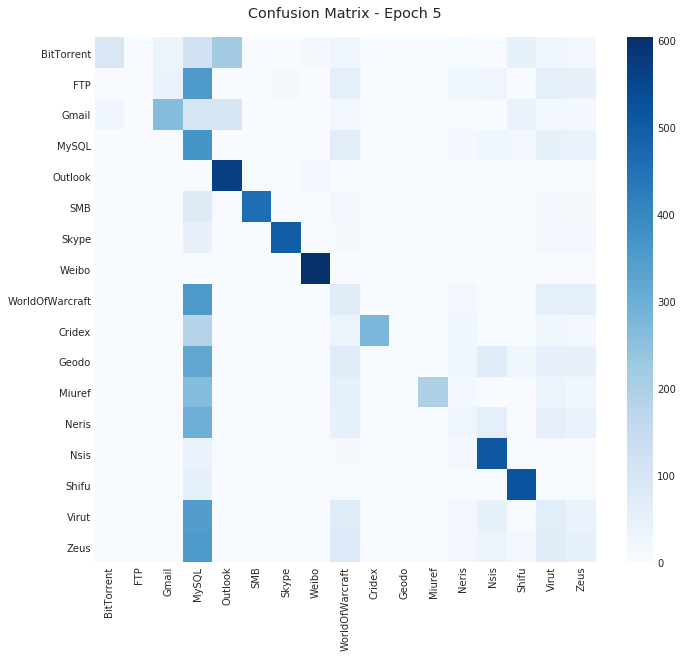

In [150]:
draw_cm(5)

plt.title('Confusion Matrix - Epoch 5', pad=20)
plt.gcf().set_size_inches(10, 9)
plt.show()

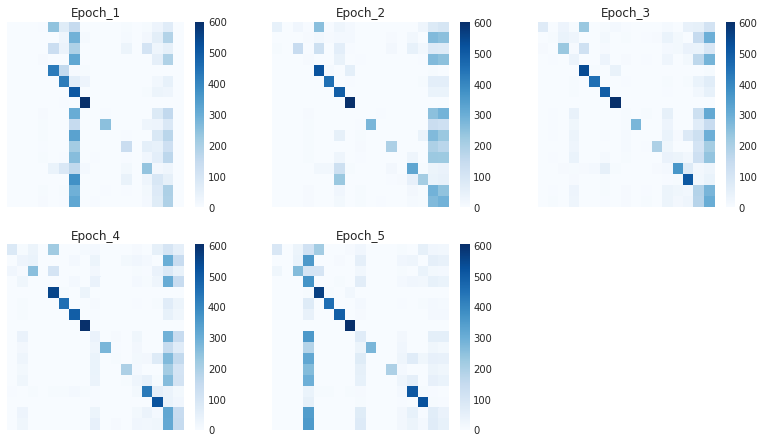

In [176]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7), sharey=True)

for i in range(2):
    for j in range(3):
        if i==1 and j==2:
            break
        g = draw_cm(checkpoint=i*3+j+1, ax=ax[i, j])
        g.set_xticks([])
        g.set_yticks([])
        g.set_title('Epoch_{}'.format(i*3+j+1), fontsize=12, pad=5)

fig.delaxes(ax[1, 2])
fig.show()

In [199]:
flow_embedding = np.load('results/flow_embedding.npy')
print(flow_embedding.shape)

(10000, 256)


In [200]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
flow_embedding_reduced = pd.DataFrame(pca.fit_transform(flow_embedding))
flow_embedding_reduced['type'] = test_y

print(flow_embedding_reduced.shape)

(10000, 3)


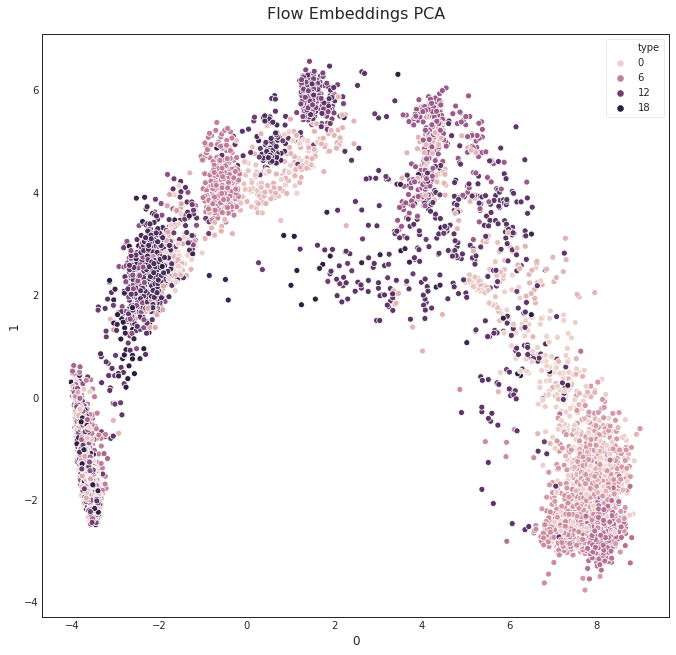

In [208]:
sns.scatterplot(
    x=0, y=1,
    data=flow_embedding_reduced,
    hue='type'
)

plt.title('Flow Embeddings PCA', fontsize=16, pad=15)
plt.gcf().set_size_inches(10, 10)
plt.show()

In [203]:
from sklearn.manifold import TSNE

tsne = TSNE(learning_rate=100)
flow_embedding_tsne = tsne.fit_transform(flow_embedding)

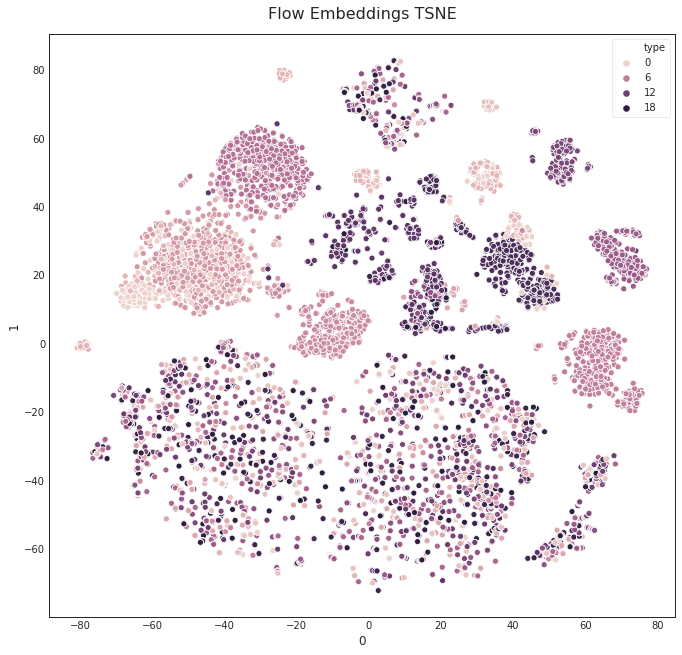

In [209]:
flow_embedding_tsne = pd.DataFrame(flow_embedding_tsne)
flow_embedding_tsne['type'] = test_y

sns.scatterplot(
    x=0, y=1,
    data=flow_embedding_tsne,
    hue='type'
)

plt.title('Flow Embeddings TSNE', fontsize=16, pad=15)
plt.gcf().set_size_inches(10, 10)
plt.show()